# Sample notebook

This notebook represents a sample model development process with many critical flaws and typical shortcommings.

It was created for instructional purposed on how NOT to do things. Please DO NOT use for any real modeling!

## Setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

## Data loading

For the purpose of this tutorial, we will use an artifically generated dataset based on a [California Housing Dataset](https://github.com/ageron/handson-ml/tree/master/datasets/housing) from [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://eliot.readthedocs.io/en/stable/) by Geron Aurelien. 

In [3]:
# Uncomment on Michael's copmuter
# df = pd.read_csv("/home/michael/data.csv")
# Download from http://some.link/that/does/not/work/anymore.csv
df = pd.read_csv("data/housing.csv")

In [4]:
df

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,location,near_ocean
0,"193,734.11",None,2229.0,542.0,559.0,4.18,38.76 N 124.85 W,Yes
1,"293,063.40",33.22,2111.0,356.0,364.0,5.35,32.32 N 102.63 W,No
2,"237,055.75",19.66,3314.0,975.0,781.0,4.33,32.69 N 117.07 W,yes
3,"373,789.89",29.8,1810.0,230.0,296.0,6.03,37.4 N 122.94 W,Yes
4,"59,804.22",14.21,3021.0,840.0,775.0,1.81,36.46 N 129.12 W,no
...,...,...,...,...,...,...,...,...
9995,"140,065.16",16.66,725.0,240.0,211.0,2.70,39.02 N 121.58 W,Yes
9996,"161,536.46",25.5,1013.0,157.0,164.0,4.87,43.64 N 129.87 W,No
9997,"87,789.04",27.97,723.0,234.0,224.0,1.76,35.19 N 136.01 W,Yes
9998,"58,109.50",28.91,3188.0,659.0,582.0,1.35,40.03 N 106.03 W,No


In [5]:
# change some columns to numeric
df.median_house_value = df.median_house_value.replace({',': ''}, regex=True).apply(pd.to_numeric, 1)
df.median_house_value = df.median_house_value.astype(float)

In [6]:
df["housing_median_age"] = pd.to_numeric(df["housing_median_age"], errors="coerce")

In [7]:
df.head()

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,location,near_ocean
0,193734.11,NaN,2229.0,542.0,559.0,4.18,38.76 N 124.85 W,Yes
1,293063.40,33.22,2111.0,356.0,364.0,5.35,32.32 N 102.63 W,No
2,237055.75,19.66,3314.0,975.0,781.0,4.33,32.69 N 117.07 W,yes
3,373789.89,29.80,1810.0,230.0,296.0,6.03,37.4 N 122.94 W,Yes
4,59804.22,14.21,3021.0,840.0,775.0,1.81,36.46 N 129.12 W,no


### Parse the "location" column into "latitude" and "longitude"

"34.56 N 123.45 W" -> 34.56, -123.45 

In [8]:
df = df.join(
    df["location"].str.extract("([1-9][0-9]{0,2}\.[0-9]{2}) [NS] ([1-9][0-9]{0,2}\.[0-9]{2}) W").rename(
        columns={0: "latitude", 1: "longitude"}).astype(float)
)
df["longitude"] *= -1

In [9]:
df.drop(columns=["location"], inplace=True)

In [10]:
df.head()

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,near_ocean,latitude,longitude
0,193734.11,NaN,2229.0,542.0,559.0,4.18,Yes,38.76,-124.85
1,293063.40,33.22,2111.0,356.0,364.0,5.35,No,32.32,-102.63
2,237055.75,19.66,3314.0,975.0,781.0,4.33,yes,32.69,-117.07
3,373789.89,29.80,1810.0,230.0,296.0,6.03,Yes,NaN,NaN
4,59804.22,14.21,3021.0,840.0,775.0,1.81,no,36.46,-129.12


### Convert "near_ocean" to `bool`

In [11]:
df["near_ocean"] = df["near_ocean"].apply(lambda near_ocean: 1 if near_ocean == "Yes" else 0)

## Data review

In [12]:
df.head()

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,near_ocean,latitude,longitude
0,193734.11,NaN,2229.0,542.0,559.0,4.18,1,38.76,-124.85
1,293063.40,33.22,2111.0,356.0,364.0,5.35,0,32.32,-102.63
2,237055.75,19.66,3314.0,975.0,781.0,4.33,0,32.69,-117.07
3,373789.89,29.80,1810.0,230.0,296.0,6.03,1,NaN,NaN
4,59804.22,14.21,3021.0,840.0,775.0,1.81,0,36.46,-129.12


In [13]:
df.describe()

,median_house_value,housing_median_age,total_rooms,total_bedrooms,households,median_income,near_ocean,latitude,longitude
count,10000.000000,9908.000000,10000.000000,9900.000000,10000.000000,10000.000000,10000.00000,8029.000000,8029.000000
mean,206235.094758,28.597311,2619.040600,536.740707,499.303200,3.869342,0.52480,35.584317,-119.570199
std,115715.318790,12.997030,2108.678306,410.428175,377.055102,1.923917,0.49941,4.145291,12.072141
min,14728.440000,1.020000,13.000000,3.000000,2.000000,0.490000,0.00000,20.970000,-160.910000
25%,120014.447500,18.200000,1440.000000,295.000000,279.000000,2.520000,0.00000,32.730000,-127.750000
50%,179266.105000,28.460000,2122.000000,433.000000,409.000000,3.500000,1.00000,35.420000,-119.520000
75%,264141.642500,37.642500,3160.000000,655.000000,607.000000,4.790000,1.00000,38.350000,-111.380000
max,644578.480000,69.040000,39232.000000,6458.000000,6562.000000,18.140000,1.00000,52.560000,-70.260000


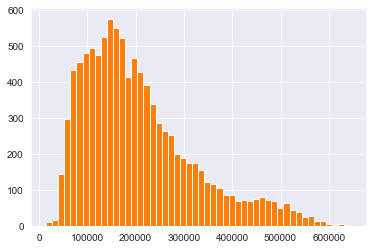

In [14]:
plt.hist(df["median_house_value"], bins=50, color="C1")
plt.show()

## Data preparation

In [15]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_household"] = df["total_bedrooms"] / df["households"]

In [16]:
df["const"] = 1

In [17]:
df.dropna(inplace=True)

## Train a linear model

In [18]:
target_var = "median_house_value"
features = list(df.columns)
features.remove(target_var)

In [19]:
model = sm.GLM(df[target_var], df[features]).fit()

## Evaluate model

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     median_house_value   No. Observations:                 7876
Model:                            GLM   Df Residuals:                     7865
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                      6.5140e+09
Method:                          IRLS   Log-Likelihood:            -1.0016e+05
Date:                Tue, 05 Nov 2019   Deviance:                   5.1233e+13
Time:                        17:44:40   Pearson chi2:                 5.12e+13
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
housing_median_age      1449.0827     76.945     18.833      0.000    1298.273    1599.893
total_rooms              -10.6133      1.583     -6.707      0.000     -13.715      -7.512
total_bedrooms            66.4847     10.807      6.152      0.000      45.303      87.667
households                16.3739      9.813      1.669      0.095      -2.860      35.607
median_income           4.125e+04    618.191     66.734      0.000       4e+04    4.25e+04
near_ocean              3.596e+04   1956.687     18.377      0.000    3.21e+04    3.98e+04
latitude                -316.8243    222.293     -1.425      0.154    -752.511     118.862
longitude                -71.3610     75.584     -0.944      0.345    -219.504      76.782
rooms_per_household     -576.7304   1032.579     -0.559      0.576   -2600.549    1447.088
bedrooms_per_household  7725.2923   5143.854      1.502      0.133   -2356.477    1.78e+04
const                  -3.284e+04   1.25e+04     -2.621      0.009   -5.74e+04   -8280.830
==========================================================================================
"""

### Calculate Root Mean Square Error

In [21]:
import math

In [22]:
def rmse(x, y):
    N = len(x)
    errors = 0
    
    for i in range(N):
        errors += (x[i] - y[i]) ** 2
    
    return math.sqrt(errors / N)

In [23]:
rmse(model.predict(), df[target_var].values)

80653.0813702978

### Calculate Model Lift

The lift statistic measures the power of discrimination of the model. Lift essentially measures the area between the cumulative percentage of actual and cumulative percentage of weight (random model). The lift ratio is then the ratio of lift when ordered by predicted to lift when ordered by actual.

To calculate it, we first sort the data according to the target variable (actual median house value) in a descending order and calculate *lift* for each observation (row) as

> lift  = 2 &times; (cm_pct_actual - cm_pct_weight) / total_weight

where
* cm_pct_actual is the cummulative percentage of total house value up to the given observation
* cm_pct_weight is the cummulative percentage of total observation weights

For simplicity, we give each observation in the dataset an equal weight of 1

In [24]:
def calc_lift(values, weights):
    cm_value = 0
    cm_value_pct = 0
    cm_weight = 0
    cm_weight_pct = 0
    
    lift = 0
    
    for value,weight in zip(values, weights):
        cm_value += value
        cm_value_pct = cm_value / values.sum()
        cm_weight += weight
        cm_weight_pct = cm_weight / weights.sum()
        
        lift += 2 * (cm_value_pct - cm_weight_pct) / weights.sum()
        
    return lift

In [25]:
calc_lift(df.sort_values(target_var, ascending=False)[target_var], np.ones(len(df)))

0.30345846888699096

Then we calculate lift when sorted by the predicted value

In [26]:
df["predictions"] = model.predict()

In [27]:
calc_lift(df.sort_values("predictions", ascending=False)[target_var], np.ones(len(df)))

0.22171007243500312